## Your name and UNI

# Deep Learning In Biomedical Imaging
## BMENE4460-2022-1

### <span style="color:red">Course Project</span> - Fast CBV-fMRI Acquisition without Contrast Agent


#### Note that portions of this workbook are adapted from Prof. Guo's Assignment 2 and Midterm Exam.

[1] Guo, Jia. Deep Learning in Biomedical Imaging BMEN 4460. Columbia University 2022. https://courseworks2.columbia.edu/courses/145230

Additional adaption of code is indicated in the code base below

[2] https://towardsdatascience.com/residual-network-implementing-resnet-a7da63c7b278

Import the necessary packages.

In [1]:
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.metrics import confusion_matrix, accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import TensorDataset, DataLoader,ConcatDataset

from PIL import Image

Check GPU availability (should be False if you run without GPU Accelerator, to turn it on, go to Settings->Accelerator on the right panel and select GPU).

In [2]:
cuda = torch.cuda.is_available()
print("GPU available:", cuda)

GPU available: True


Set the Random Seed

In [3]:
torch.manual_seed(4460)
np.random.seed(4460)

Show the number of images we have in the training, validation and test sets

In [4]:
!ls "/kaggle/input/finaldata/pngProjectData/input folder/Test" | wc -l

9


In [5]:
!ls "/kaggle/input/finaldata/pngProjectData/input folder/Train" | wc -l

46


In [6]:
!ls "/kaggle/input/finaldata/pngProjectData/input folder/Valid" | wc -l

9


Create the dataloaders

In [7]:
data_root_folder = '../input/finaldata/pngProjectData/input folder/'
truth_root_folder = '../input/finaldata/pngProjectData/ground truth folder/'
numSlices = 18
actualImgSize = 201
imageDim = 208
numTest = 9
numValid = 0
numTrain = 46

class BasicDataset(TensorDataset):
    # This function takes folder name ('train', 'valid', 'test') as input and creates an instance of BasicDataset according to that folder.
    # Also if you'd like to have less number of samples (for evaluation purposes), you may set the `n_sample` with an integer.
    def __init__(self, folder, n_sample=None):
        self.imgs_dir = os.path.join(data_root_folder, folder)
        self.masks_dir = os.path.join(truth_root_folder, folder)
        #self.imgs_dir = os.path.join(self.folder, 'image')
        #self.masks_dir = os.path.join(self.folder, 'mask')
        
        self.img_dirs = sorted(glob.glob(os.path.join(self.imgs_dir, '*.gz')))
        self.mask_dirs = sorted(glob.glob(os.path.join(self.masks_dir, '*.gz')))
        
        assert len(self.img_dirs) == len(self.mask_dirs), 'There are some missing images or masks in {0}'.format(folder)
        
        # If n_sample is not None (It has been set by the user)
        if not n_sample or n_sample > len(self.img_dirs):
            n_sample = len(self.img_dirs)
        
        self.n_sample = n_sample
        self.ids = list([i+1 for i in range(n_sample)])
            
    # This function returns the lenght of the dataset (AKA number of samples in that set)
    def __len__(self):
        return self.n_sample
    
    
    # This function takes an index (i) which is between 0 to `len(BasicDataset)` (The return of the previous function), then returns RGB image, 
    # mask (Binary), and the index of the file name (Which we will use for visualization). The preprocessing step is also implemented in this function.
    def __getitem__(self, i):
        idx = self.ids[i]
        fileName = self.img_dirs[i]
        maskFileName = self.mask_dirs[i]
        
        ### RUN THIS SECTION FOR ALL 18 CHANNELS AT ONCE ------------------------------------
        # Initialize array for all 18 channels
        imageData = np.zeros((imageDim,imageDim,numSlices))
        maskData = np.zeros((imageDim,imageDim,numSlices))
        
        for i in range(numSlices):
            #img = cv2.imread(os.path.join(fileName, str(i)+'.png'), cv2.IMREAD_COLOR)
            img = cv2.imread(os.path.join(fileName, str(i)+'.png'),cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(os.path.join(maskFileName, str(i)+'.png'),cv2.IMREAD_GRAYSCALE)
            
            try:
                #img = cv2.resize(img, (imageDim,imageDim))
                #mask = cv2.resize(mask, (imageDim,imageDim))
                img = cv2.resize(img, (imageDim,imageDim),interpolation = cv2.INTER_AREA)
                mask = cv2.resize(mask, (imageDim,imageDim),interpolation = cv2.INTER_AREA)
            
            except Exception as e:
                print(str(e))
                print(str(os.path.join(fileName, str(i)+'.png')))
            
            # Put the image slice into the data array
            imageData[:,:,i] = np.asarray(img) 
            maskData[:,:,i] = np.asarray(mask) 
           
        # HWC to CHW
        imageData = np.transpose(imageData, (2, 0, 1))
        maskData = np.transpose(maskData, (2, 0, 1))
        
        ### RUN THIS SECTION TO ONLY LOOK AT ONE SLICE PER PATIENT---------------------------
        
        '''# Initialize arrays for one slice from each patient
        imageData = np.zeros((imageDim,imageDim,1))
        maskData = np.zeros((imageDim,imageDim,1))
        
        # Choose which slice we want to use
        i = 6
        
        img = cv2.imread(os.path.join(fileName, str(i)+'.png'),cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(os.path.join(maskFileName, str(i)+'.png'),cv2.IMREAD_GRAYSCALE)
        
        # Resize the images
        img = cv2.resize(img, (imageDim,imageDim),interpolation = cv2.INTER_AREA)
        mask = cv2.resize(mask, (imageDim,imageDim),interpolation = cv2.INTER_AREA)
        
        # Put the image in
        imageData[:,:,0] = np.asarray(img)
        maskData[:,:,0] = np.asarray(mask)
        
        # HWC to CHW
        imageData = np.transpose(imageData, (2, 0, 1))
        maskData = np.transpose(maskData, (2, 0, 1))'''
        
        ### --------------------------------------------------------------------------------
        
        # Scale between 0 to 1
        imageData = imageData / 255.0
        maskData = maskData / 255.0
        

        return {
            'image': torch.from_numpy(imageData).type(torch.FloatTensor),
            'mask': torch.from_numpy(maskData).type(torch.FloatTensor),
            'img_id': idx
        }

Show some of the datasets for information

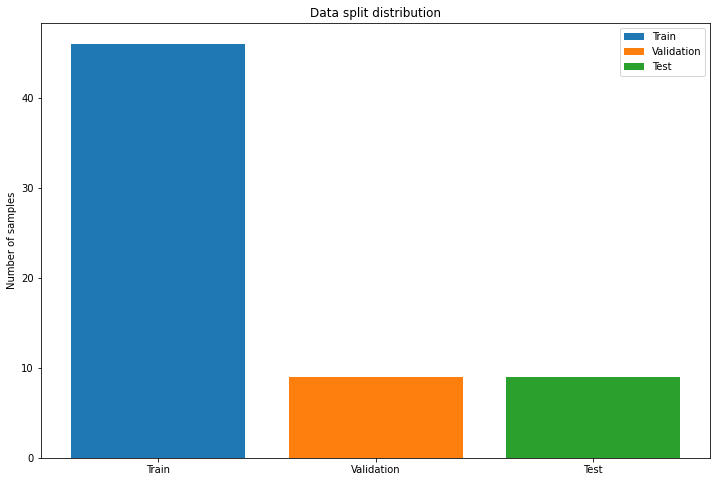

In [8]:
# Create train, validation, and test dataset instances
train_dataset = BasicDataset('Train')
valid_dataset = BasicDataset('Valid')
test_dataset = BasicDataset('Test')

plt.figure(figsize=(12,8))
plt.title('Data split distribution')
plt.bar(0, len(train_dataset), label='Train')
plt.bar(1, len(valid_dataset), label='Validation')
plt.bar(2, len(test_dataset), label='Test')
plt.ylabel('Number of samples')
plt.xticks([0,1,2],['Train', 'Validation', 'Test'])
plt.legend()
plt.show()

Plot an example image

x shape is torch.Size([18, 208, 208])
y shape is torch.Size([18, 208, 208])


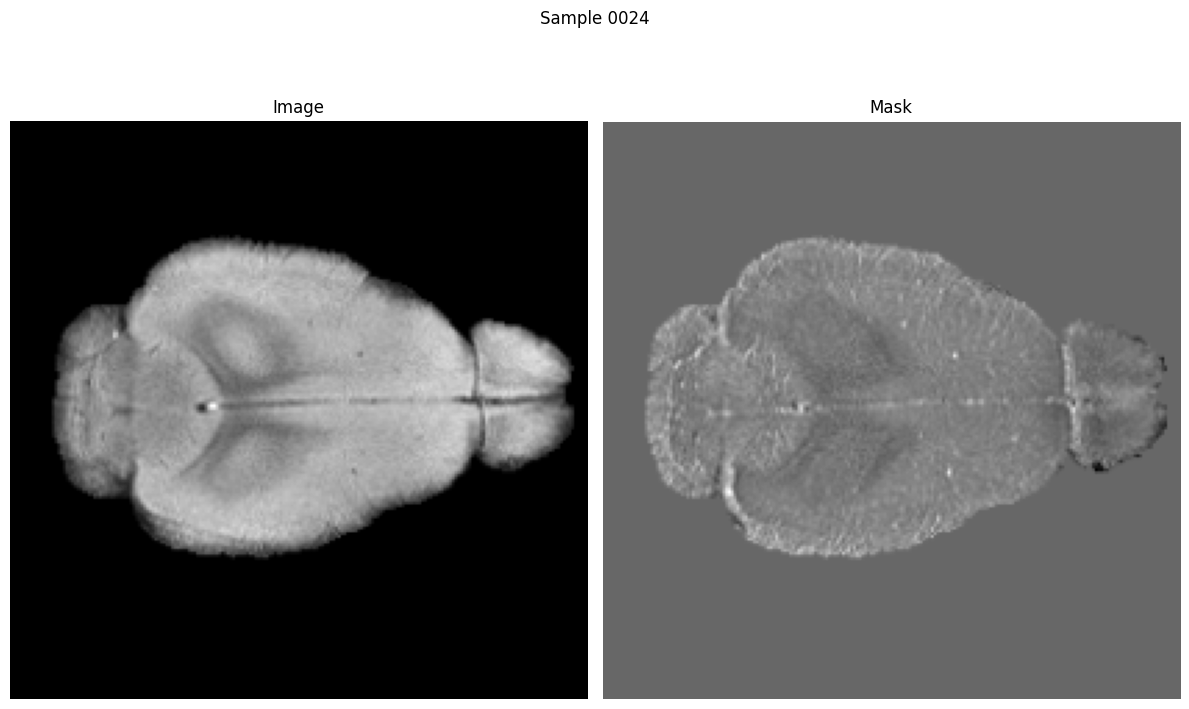

In [9]:
sample = np.random.randint(0, len(train_dataset))
data = train_dataset.__getitem__(sample)
x = data['image']
y = data['mask']
idx = data['img_id']

print(f'x shape is {x.shape}')
print(f'y shape is {y.shape}')

plt.figure(figsize=(12, 8), dpi=100)
plt.suptitle(f'Sample {idx:04d}')

## USE THIS SECTION IF USING ALL 18 CHANNELS
img = x[3,:,:]
mask = y[3,:,:]

## USE THIS SECTION IF USING ONLY ONE CHANNEL PER PATIENT
#img = x[0,:,:]
#mask = y[0,:,:]


plt.subplot(1, 2, 1)
plt.title('Image')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Mask')
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

Create the dataloaders

In [10]:
# Re-create train, validation, and test dataset instances to reduce the number of samples and expedite the training process.
train_dataset = BasicDataset('Train', n_sample=numTrain)
valid_dataset = BasicDataset('Valid', n_sample=numValid)
test_dataset = BasicDataset('Test', n_sample=numTest)

train_dataloader = DataLoader(train_dataset, batch_size=3, shuffle=True, num_workers=2, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=3, num_workers=2, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=3, num_workers=2, pin_memory=True)

Create the DL Network

In [11]:
######################################## Double Convolution
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

    
######################################## Maxpooling followed by Double Convolution
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


######################################## Upsampling followed by Double Convolution
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up_conv = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0),
        ) 
        self.conv = DoubleConv(out_channels * 2, out_channels)


    def forward(self, x1, x2):
        x1 = self.up_conv(x1)
        x = torch.cat([x1, x2], dim=1)
        x = self.conv(x)
        return x

######################################## Output layer (1x1 Convolution followed by SoftMax activation)
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv_sigmoid = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.conv_sigmoid(x)

Put the layers together

In [12]:
class UNet(nn.Module):
    
    
    
    def __init__(self, name, n_channels, n_classes):
        super(UNet, self).__init__()
        self.name = name
        self.n_channels = n_channels
        self.n_classes = n_classes
        '''[(Q3) Adding additional encoding and decoding layers below]'''
        self.inputL = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outputL = OutConv(64, n_classes)
        
        '''[(Q3) Modify the forward module below]'''
    def forward(self, x):
        x1 = self.inputL(x)
        
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        b = self.down4(x4)
        
        x = self.up1(b, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        x = self.outputL(x)
        
        return x

Instantiate our model

In [13]:
## USE THIS IF USING ALL 18 CHANNELS
# define the channel number first
inp_channel = 18
opt_channel = 18


## USE THIS IF ONLY USING ONE CHANNEL PER PATIENT
#inp_channel = 1
#opt_channel = 2


my_UNet = UNet('MyUNet', inp_channel, opt_channel)
my_UNet.cuda()

UNet(
  (inputL): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(18, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, mo

Define optimizer and loss function

In [14]:
optimizer = torch.optim.Adam(my_UNet.parameters(), lr=0.001)
#loss_function = nn.CrossEntropyLoss()
loss_function = nn.BCELoss()

Implement training loop with modified version of Jaccard Index

In [15]:
# Define a function that computes the Jaccard score for binary segmentation
def jaccard_index(y_pred, y_true):
        '''[(Q5) Your answer here - hint: check the equation of Jaccard Index here:https://en.wikipedia.org/wiki/Jaccard_index, do not use predefined jaccard index functions provided in any libraries ]'''
        eps = 0.0001
        intersection = torch.dot(y_pred.view(-1).float(), y_true.view(-1).float())
        union = 0.5*(torch.sum(y_pred).float() + torch.sum(y_true).float())
        jaccard_index = ((intersection.float() + eps)/(union.float() - intersection.float() + eps)).cpu().detach().numpy()       
        return jaccard_index

# The training function
def train_net(net, epochs, train_dataloader, valid_dataloader, optimizer, loss_function):
    
    if not os.path.isdir('{0}'.format(net.name)):
        os.mkdir('{0}'.format(net.name))
    
    n_train = len(train_dataloader)
    n_valid = len(valid_dataloader)    
    
    train_loss = list()
    valid_loss = list()
    #train_dice = list()
    #valid_dice = list()
    train_jaccard = list()
    valid_jaccard = list()
    
    for epoch in range(epochs):
        
        ################################################################################################################################
        ########################################################### Training ###########################################################
        ################################################################################################################################
        net.train()
        train_batch_loss = list()
        #train_batch_dice = list()
        train_batch_jaccard = list()
        
        for i, batch in enumerate(train_dataloader):

            # Load a batch and pass it to the GPU
            imgs = batch['image'].cuda()
            true_masks = batch['mask'].cuda()

            # Produce the estimated mask using current weights
            y_pred = net(imgs)

            # Compute the loss for this batch and append it to the epoch loss
            loss = loss_function(y_pred, true_masks)
            batch_loss = loss.item()
            train_batch_loss.append(batch_loss)

            # Make the binary mask to compute the DICE score. Since the y_pred is a Pytoch tensor, we use `torch.argmax()` instead of `np.argmax()`.
            # the axis must be 1 instead of 0 because the format is [batch, channel, height, width]
            pred_binary = torch.argmax(y_pred, axis=1)
            
            # Compute the DICE score for this batch and append it to the epoch dice
            #batch_dice_score = dice_coeff_binary(pred_binary, true_masks)
            #train_batch_dice.append(batch_dice_score)
            
            # Compute the Jaccard score here and 
            #batch_jaccard_score = jaccard_index(pred_binary, true_masks)
            batch_jaccard_score = jaccard_index(y_pred, true_masks)
            train_batch_jaccard.append(batch_jaccard_score)
            

            # Reset gradient values
            optimizer.zero_grad()

            # Compute the backward losses
            loss.backward()

            # Update the weights
            optimizer.step()
            
            # Print the progress
            print(f'EPOCH {epoch + 1}/{epochs} - Training Batch {i+1}/{n_train} - Loss: {batch_loss}, Jaccard score: {batch_jaccard_score}            ', end='\r')
        
        average_training_loss = np.array(train_batch_loss).mean()
        #average_training_dice = np.array(train_batch_dice).mean()
        average_training_jaccard = np.array(train_batch_jaccard).mean()
        train_loss.append(average_training_loss)
        #train_dice.append(average_training_dice)
        train_jaccard.append(average_training_jaccard)
        
        ################################################################################################################################
        ########################################################## Validation ##########################################################
        ################################################################################################################################
        
        net.eval()
        valid_batch_loss = list()
        #valid_batch_dice = list()
        valid_batch_jaccard = list()
        
        # This part is almost the same as training with the difference that we will set all layers to evaluation mode (effects some layers such as BN and Dropout) and also
        # we don't need to calculate the gradient since we are only evaluating current state of the model. This will speed up the process and cause it to consume less memory.
        with torch.no_grad():
            for i, batch in enumerate(valid_dataloader):

                # Load a batch and pass it to the GPU
                imgs = batch['image'].cuda()
                true_masks = batch['mask'].cuda()

                # Produce the estimated mask using current weights
                y_pred = net(imgs)

                # Compute the loss for this batch and append it to the epoch loss
                loss = loss_function(y_pred, true_masks)
                batch_loss = loss.item()
                valid_batch_loss.append(batch_loss)

                # Make the binary mask to compute the DICE score. Since the y_pred is a Pytoch tensor, we use `torch.argmax()` instead of `np.argmax()`.
                # the axis must be 1 instead of 0 because the format is [batch, channel, height, width]
                pred_binary = torch.argmax(y_pred, axis=1)

                # Compute the DICE score for this batch and append it to the epoch dice
                #batch_dice_score = dice_coeff_binary(pred_binary, true_masks)
                #valid_batch_dice.append(batch_dice_score)
                
                # Compute the Jaccard score here and append the score to the list
                #batch_jaccard_score = jaccard_index(pred_binary, true_masks)
                batch_jaccard_score = jaccard_index(y_pred, true_masks)
                valid_batch_jaccard.append(batch_jaccard_score)

                # Print the progress
                print(f'EPOCH {epoch + 1}/{epochs} - Validation Batch {i+1}/{n_valid} - Loss: {batch_loss}, Jaccard score: {batch_jaccard_score}            ', end='\r')
                
        average_validation_loss = np.array(valid_batch_loss).mean()
        #average_validation_dice = np.array(valid_batch_dice).mean()
        average_validation_jaccard = np.array(valid_batch_jaccard).mean()
        valid_loss.append(average_validation_loss)
        #valid_dice.append(average_validation_dice)
        valid_jaccard.append(average_validation_jaccard)
        
        print(f'EPOCH {epoch + 1}/{epochs} - Training Loss: {average_training_loss}, Training Jaccard score: {average_training_jaccard}, Validation Loss: {average_validation_loss}, Validation Jaccard score: {average_validation_jaccard}')

        ################################################################################################################################
        ###################################################### Saveing Checkpoints #####################################################
        ################################################################################################################################
        torch.save(net.state_dict(), f'{net.name}/epoch_{epoch+1:03}.pth')
    
    return train_loss, train_jaccard, valid_loss, valid_jaccard

Run the training for 100 Epochs

In [16]:
EPOCHS = 100
train_loss, train_jaccard, valid_loss, valid_jaccard = train_net(my_UNet, EPOCHS, train_dataloader, valid_dataloader, optimizer, loss_function)

EPOCH 1/100 - Training Loss: 0.6655381917953491, Training Jaccard score: 0.6990534067153931, Validation Loss: 0.6491161187489828, Validation Jaccard score: 0.6763284802436829
EPOCH 2/100 - Training Loss: 0.64242148026824, Training Jaccard score: 0.6512935757637024, Validation Loss: 0.6305385828018188, Validation Jaccard score: 0.6550686955451965
EPOCH 3/100 - Training Loss: 0.634218517690897, Training Jaccard score: 0.6477567553520203, Validation Loss: 0.6508787473042806, Validation Jaccard score: 0.6547192931175232
EPOCH 4/100 - Training Loss: 0.6332935504615307, Training Jaccard score: 0.6578209400177002, Validation Loss: 0.6257654825846354, Validation Jaccard score: 0.6540104746818542
EPOCH 5/100 - Training Loss: 0.6307727731764317, Training Jaccard score: 0.6482549905776978, Validation Loss: 0.623017946879069, Validation Jaccard score: 0.6569147109985352
EPOCH 6/100 - Training Loss: 0.6324248313903809, Training Jaccard score: 0.661525547504425, Validation Loss: 0.6207544008890787, 

Display the learning curves

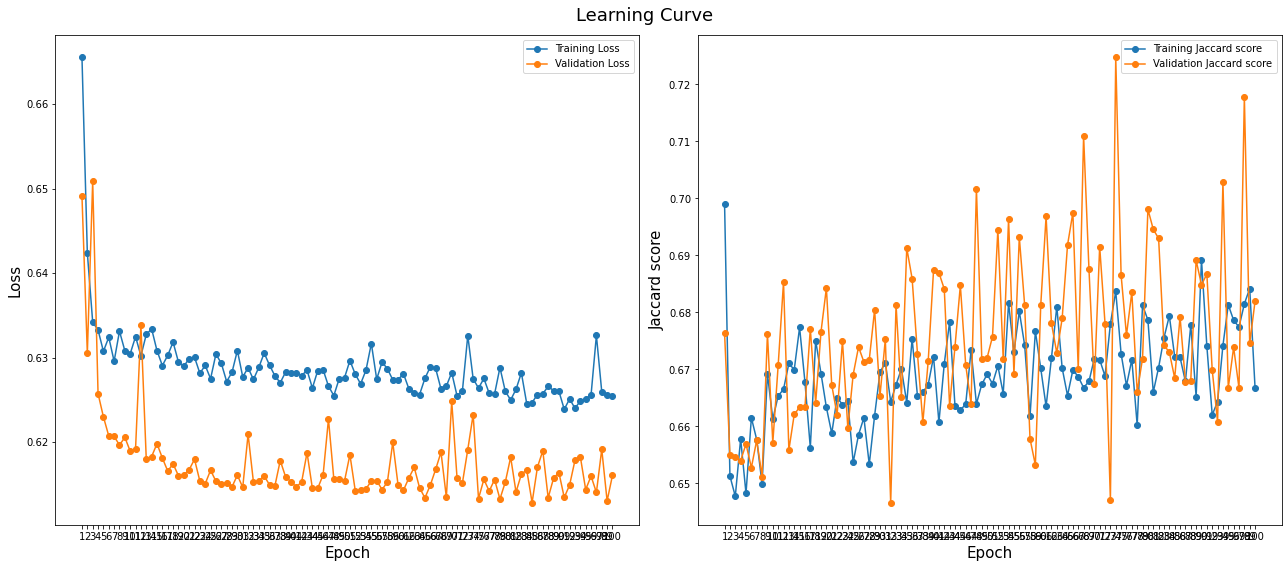

In [17]:
plt.figure(figsize=(18,8))
plt.suptitle('Learning Curve', fontsize=18)

plt.subplot(1,2,1)
plt.plot(np.arange(EPOCHS)+1, train_loss, '-o', label='Training Loss')
plt.plot(np.arange(EPOCHS)+1, valid_loss, '-o', label='Validation Loss')
plt.xticks(np.arange(EPOCHS)+1)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend()

plt.subplot(1,2,2)
plt.plot(np.arange(EPOCHS)+1, train_jaccard, '-o', label='Training Jaccard score')
plt.plot(np.arange(EPOCHS)+1, valid_jaccard, '-o', label='Validation Jaccard score')
plt.xticks(np.arange(EPOCHS)+1)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Jaccard score', fontsize=15)
plt.legend()

plt.tight_layout()
plt.show()

Find the best model

In [18]:
best_epoch = np.argmax(valid_jaccard) + 1 # The plus one is because the epochs starts at 1.

print(f'Best epoch is epoch{best_epoch}')

state_dict = torch.load(f'./MyUNet/epoch_{best_epoch:03}.pth')

my_UNet.load_state_dict(state_dict)
my_UNet.cuda()

Best epoch is epoch74


UNet(
  (inputL): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(18, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, mo

Run the model for a random test sample

Sample batch 'image 'shape is: torch.Size([3, 18, 208, 208])
Sample batch 'mask' shape is: torch.Size([3, 18, 208, 208])
Predicted mask shape is: torch.Size([3, 18, 208, 208])


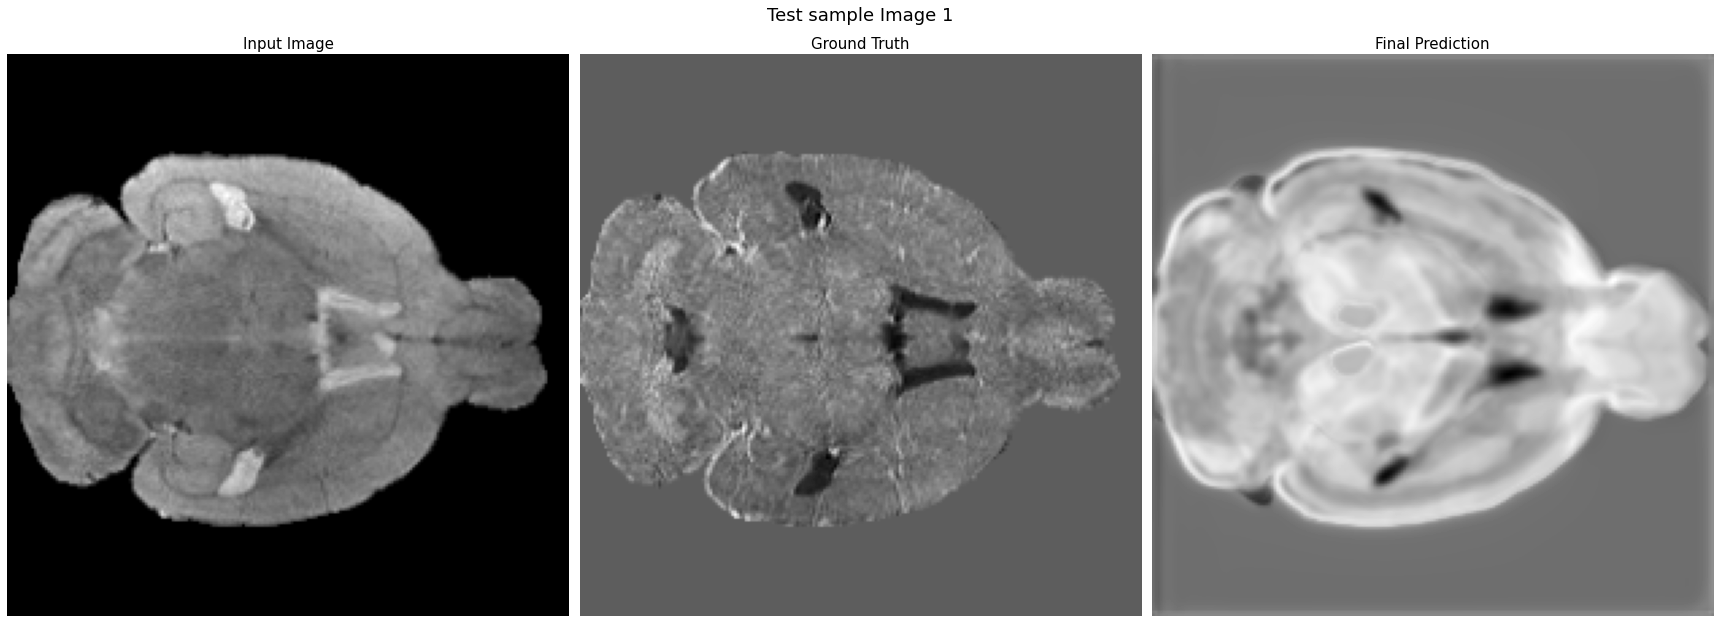

In [19]:
# Take the first batch of test set
for batch in test_dataloader:
    sample_batch = batch
    break
    
# Generat network prediction
with torch.no_grad():
    y_pred = my_UNet(sample_batch['image'].cuda())

# Print the shapes of the images, masks, predicted masks
print('Sample batch \'image \'shape is: {0}\nSample batch \'mask\' shape is: {1}\nPredicted mask shape is: {2}'.format(sample_batch['image'].shape, 
                                                                                                                       sample_batch['mask'].shape,
                                                                                                                       y_pred.shape
                                                                                                                      ))
# Convert Pytorch tensor to numpy array then reverse the preprocessing steps
img = (sample_batch['image'][0].numpy() * 255).astype('uint8')
msk = (sample_batch['mask'][0].numpy() * 255).astype('uint8')

# Using `np.argmax()`, we may choose the maximum likelihood to assign a label for each pixel
#pred_msk_binary = (np.argmax(y_pred.cpu().numpy()[0], axis=0) * 255).astype('uint8')
pred_msk_binary = ((y_pred.cpu().numpy()[0][8,:,:] > 0.5) * 255).astype('uint8')

# Take the image id for display
img_id = sample_batch['img_id'][0]

# Plot the smaple, ground truth, the prediction probability map, and the final predicted mask
plt.figure(figsize=(24,18))
plt.suptitle(f'Test sample Image {img_id}', fontsize=18)

plt.subplot(2,3,1)
plt.title('Input Image', fontsize=15)
plt.imshow(img[8,:,:], cmap='gray')
plt.axis('off')

plt.subplot(2,3,2)
plt.title('Ground Truth', fontsize=15)
plt.imshow(msk[8,:,:], cmap='gray')
plt.axis('off')


plt.subplot(2,3,3)
plt.title('Final Prediction', fontsize=15)
#plt.imshow(pred_msk_binary, cmap='gray')
plt.imshow(y_pred.cpu().numpy()[0][8,:,:], cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

Define the code to test the model

In [20]:
def test_net(net, test_dataloader, loss_function):
    # Create the pred_mask folder
    if not os.path.isdir('/kaggle/working/pred_mask'):
        os.mkdir('/kaggle/working/pred_mask')
    
    net.eval()
    
    n_test = len(test_dataloader)
    test_batch_loss = list()
    test_batch_jaccard = list()
    test_batch_accuray = list()
    test_batch_CM = list()

    # This part is almost the same as the validation loop in `train_net` function. 
    # The difference is that we will calculate the accuracy and confusion matrix per each batch and save the predicted images.
    with torch.no_grad():
        for i, batch in enumerate(test_dataloader):

            # Load a batch and pass it to the GPU
            imgs = batch['image'].cuda()
            true_masks = batch['mask'].cuda()
            img_ids = batch['img_id'].numpy().astype('int')

            # Produce the estimated mask using current weights
            y_pred = net(imgs)

            # Compute the loss for this batch and append it to the epoch loss
            loss = loss_function(y_pred, true_masks)
            batch_loss = loss.item()
            test_batch_loss.append(batch_loss)

            # Make the binary mask to compute the DICE score. Since the y_pred is a Pytoch tensor, we use `torch.argmax()` instead of `np.argmax()`.
            # the axis must be 1 instead of 0 because the format is [batch, channel, height, width]
            pred_binary = torch.argmax(y_pred, axis=1)
            
            # Compute the Jaccard score for this batch and append it to the epoch dice
            #batch_jaccard_score = jaccard_coeff_binary(pred_binary, true_masks)
            batch_jaccard_score = jaccard_index(y_pred, true_masks)
            test_batch_jaccard.append(batch_jaccard_score)
            
            # Save the predicted masks
            #for idx, pred_msk in enumerate(pred_binary):
            #    cv2.imwrite(f'/kaggle/working/pred_mask/pred_mask_{img_ids[idx]:04}.png', pred_msk.cpu().numpy())
            for idx, pred_m in enumerate(y_pred):
                for i in range(18):
                    #cv2.imwrite('/kaggle/working/pred_output/pred_mask_Subj_'+str(img_ids[idx])+'_'+str(i)+'.png', y_pred[0][i,:,:].cpu().numpy())
                    cv2.imwrite(f'/kaggle/working/pred_output/pred_mask_Subj{img_ids[idx]:04}_{i:02}.png', pred_m[i,:,:].cpu().numpy())
            
            # Vectorize the true mask and predicted mask for this batch
            vectorize_true_masks = true_masks.view(-1).cpu().numpy()
            vectorize_pred_masks = pred_binary.view(-1).cpu().numpy()
            
            # Compute the accuracy for this batch and append to the overall list
            #batch_accuracy = accuracy_score(vectorize_true_masks, vectorize_pred_masks)
            #test_batch_accuray.append(batch_accuracy)
            
            # Compute the normalized confusion matrix for this batch and append to the overall list
            #batch_CM = confusion_matrix(vectorize_true_masks, vectorize_pred_masks, normalize='true', labels=[0, 1])
            #test_batch_CM.append(batch_CM)

            # Print the progress
            print(f'Test Batch {i+1}/{n_test} - Loss: {batch_loss}, Jaccard score: {batch_jaccard_score}', end='\r')

    test_loss = np.array(test_batch_loss).mean()
    test_jaccard = np.array(test_batch_jaccard).mean()
    #test_accuracy = np.array(test_batch_accuray).mean()
    #test_CM = np.array(test_batch_CM).mean(axis=0)
    
    return test_loss, test_jaccard

Show RGB version of the predictions for better visualization

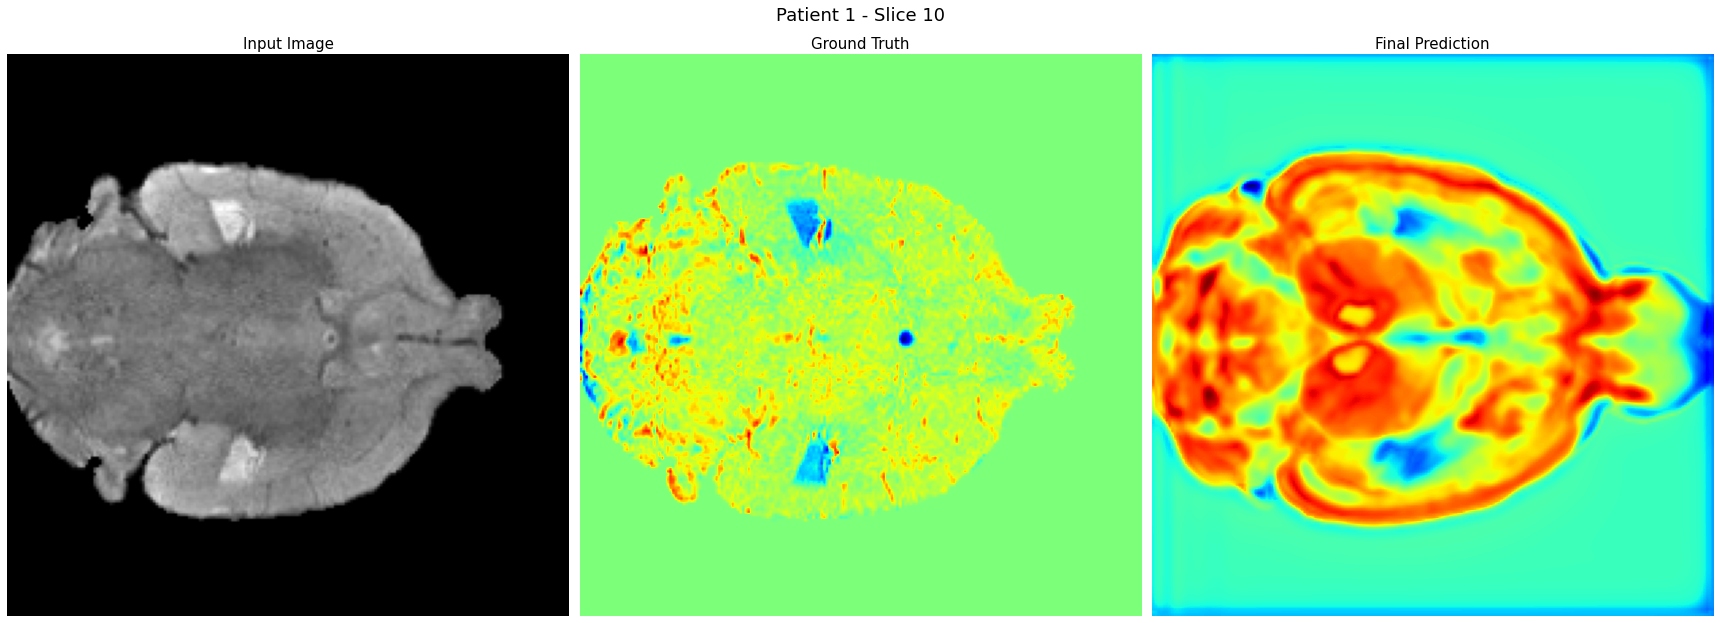

In [22]:
# Large heat outside of brain
#batchToPlot = 3
#sliceIndex = 8

# Reasonable overall performance, but heat around the borders
#batchToPlot = 0
#sliceIndex = 8

# Excellent to show boundary effects
#batchToPlot = 0
#sliceIndex = 3

# Excellent to show boundary effects
batchToPlot = 0
sliceIndex = 10

nameString = 'subj_'+str(batchToPlot) + 'slc_'+str(sliceIndex)+'.png'

# Take the first batch of test set
for i,batch in enumerate(test_dataloader):
    sample_batch = batch
    
    if i == batchToPlot:
        break
    
# Generat network prediction
with torch.no_grad():
    y_pred = my_UNet(sample_batch['image'].cuda())     
    
# Convert Pytorch tensor to numpy array then reverse the preprocessing steps
img = (sample_batch['image'][0].numpy() * 255).astype('uint8')
msk = (sample_batch['mask'][0].numpy() * 255).astype('uint8')

# Take the image id for display
img_id = sample_batch['img_id'][0]

imgToShow = img[sliceIndex,:,:]
mskToShow = msk[sliceIndex,:,:]
predToShow = y_pred.cpu().numpy()[0][sliceIndex,:,:]

# Plot the smaple, ground truth, the prediction probability map, and the final predicted mask
plt.figure(figsize=(24,18))
plt.suptitle(f'Patient {img_id} - Slice {sliceIndex}', fontsize=18)

plt.subplot(2,3,1)
plt.title('Input Image', fontsize=15)
plt.imshow(imgToShow, cmap='gray')
plt.axis('off')

plt.subplot(2,3,2)
plt.title('Ground Truth', fontsize=15)
plt.imshow(mskToShow, cmap='jet')
plt.axis('off')

plt.subplot(2,3,3)
plt.title('Final Prediction', fontsize=15)
plt.imshow(predToShow, cmap='jet')
plt.axis('off')

plt.tight_layout()

plt.savefig(nameString)

plt.show()

Set up a new loader which will perform image augmentation also

In [24]:
import random

class BasicDataset(TensorDataset):
    # This function takes folder name ('train', 'valid', 'test') as input and creates an instance of BasicDataset according to that folder.
    # Also if you'd like to have less number of samples (for evaluation purposes), you may set the `n_sample` with an integer.
    def __init__(self, folder, n_sample=None):
        self.imgs_dir = os.path.join(data_root_folder, folder)
        self.masks_dir = os.path.join(truth_root_folder, folder)
        #self.imgs_dir = os.path.join(self.folder, 'image')
        #self.masks_dir = os.path.join(self.folder, 'mask')
        
        self.img_dirs = sorted(glob.glob(os.path.join(self.imgs_dir, '*.gz')))
        self.mask_dirs = sorted(glob.glob(os.path.join(self.masks_dir, '*.gz')))
        
        assert len(self.img_dirs) == len(self.mask_dirs), 'There are some missing images or masks in {0}'.format(folder)
        
        # If n_sample is not None (It has been set by the user)
        if not n_sample or n_sample > len(self.img_dirs):
            n_sample = len(self.img_dirs)
        
        self.n_sample = n_sample
        self.ids = list([i+1 for i in range(n_sample)])
            
    # This function returns the lenght of the dataset (AKA number of samples in that set)
    def __len__(self):
        return self.n_sample
    
    
    # This function takes an index (i) which is between 0 to `len(BasicDataset)` (The return of the previous function), then returns RGB image, 
    # mask (Binary), and the index of the file name (Which we will use for visualization). The preprocessing step is also implemented in this function.
    def __getitem__(self, i):
        idx = self.ids[i]
        fileName = self.img_dirs[i]
        maskFileName = self.mask_dirs[i]
        
        ### RUN THIS SECTION FOR ALL 18 CHANNELS AT ONCE ------------------------------------
        # Initialize array for all 18 channels
        imageData = np.zeros((imageDim,imageDim,numSlices))
        maskData = np.zeros((imageDim,imageDim,numSlices))
        
        for i in range(numSlices):
            #img = cv2.imread(os.path.join(fileName, str(i)+'.png'), cv2.IMREAD_COLOR)
            img = cv2.imread(os.path.join(fileName, str(i)+'.png'),cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(os.path.join(maskFileName, str(i)+'.png'),cv2.IMREAD_GRAYSCALE)
            
            try:
                #img = cv2.resize(img, (imageDim,imageDim))
                #mask = cv2.resize(mask, (imageDim,imageDim))
                img = cv2.resize(img, (imageDim,imageDim),interpolation = cv2.INTER_AREA)
                mask = cv2.resize(mask, (imageDim,imageDim),interpolation = cv2.INTER_AREA)
                
                rotationDegree = random.randrange(1,359)
                M = cv2.getRotationMatrix2D(((imageDim-1)/2.0,(imageDim-1)/2.0),rotationDegree,1)
                img = cv2.warpAffine(img,M,(imageDim,imageDim))
                mask = cv2.warpAffine(mask,M,(imageDim,imageDim))
            
            except Exception as e:
                print(str(e))
                print(str(os.path.join(fileName, str(i)+'.png')))
            
            # Put the image slice into the data array
            imageData[:,:,i] = np.asarray(img) 
            maskData[:,:,i] = np.asarray(mask) 
           
        # HWC to CHW
        imageData = np.transpose(imageData, (2, 0, 1))
        maskData = np.transpose(maskData, (2, 0, 1))
        
        ### RUN THIS SECTION TO ONLY LOOK AT ONE SLICE PER PATIENT---------------------------
        
        '''# Initialize arrays for one slice from each patient
        imageData = np.zeros((imageDim,imageDim,1))
        maskData = np.zeros((imageDim,imageDim,1))
        
        # Choose which slice we want to use
        i = 6
        
        img = cv2.imread(os.path.join(fileName, str(i)+'.png'),cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(os.path.join(maskFileName, str(i)+'.png'),cv2.IMREAD_GRAYSCALE)
        
        # Resize the images
        img = cv2.resize(img, (imageDim,imageDim),interpolation = cv2.INTER_AREA)
        mask = cv2.resize(mask, (imageDim,imageDim),interpolation = cv2.INTER_AREA)
        
        # Put the image in
        imageData[:,:,0] = np.asarray(img)
        maskData[:,:,0] = np.asarray(mask)
        
        # HWC to CHW
        imageData = np.transpose(imageData, (2, 0, 1))
        maskData = np.transpose(maskData, (2, 0, 1))'''
        
        ### --------------------------------------------------------------------------------
        
        # Scale between 0 to 1
        imageData = imageData / 255.0
        maskData = maskData / 255.0
        

        return {
            'image': torch.from_numpy(imageData).type(torch.FloatTensor),
            'mask': torch.from_numpy(maskData).type(torch.FloatTensor),
            'img_id': idx
        }

Create the new augmented dataset and plot the numbers

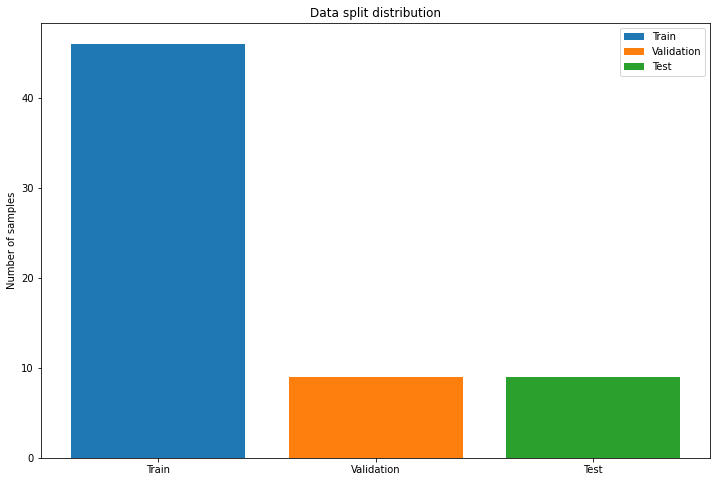

In [25]:
# Create train, validation, and test dataset instances
train_dataset_augmented = BasicDataset('Train')
valid_dataset_augmented = BasicDataset('Valid')
test_dataset_augmented = BasicDataset('Test')

plt.figure(figsize=(12,8))
plt.title('Data split distribution')
plt.bar(0, len(train_dataset_augmented), label='Train')
plt.bar(1, len(valid_dataset_augmented), label='Validation')
plt.bar(2, len(test_dataset_augmented), label='Test')
plt.ylabel('Number of samples')
plt.xticks([0,1,2],['Train', 'Validation', 'Test'])
plt.legend()
plt.show()

Show another example

x shape is torch.Size([18, 208, 208])
y shape is torch.Size([18, 208, 208])


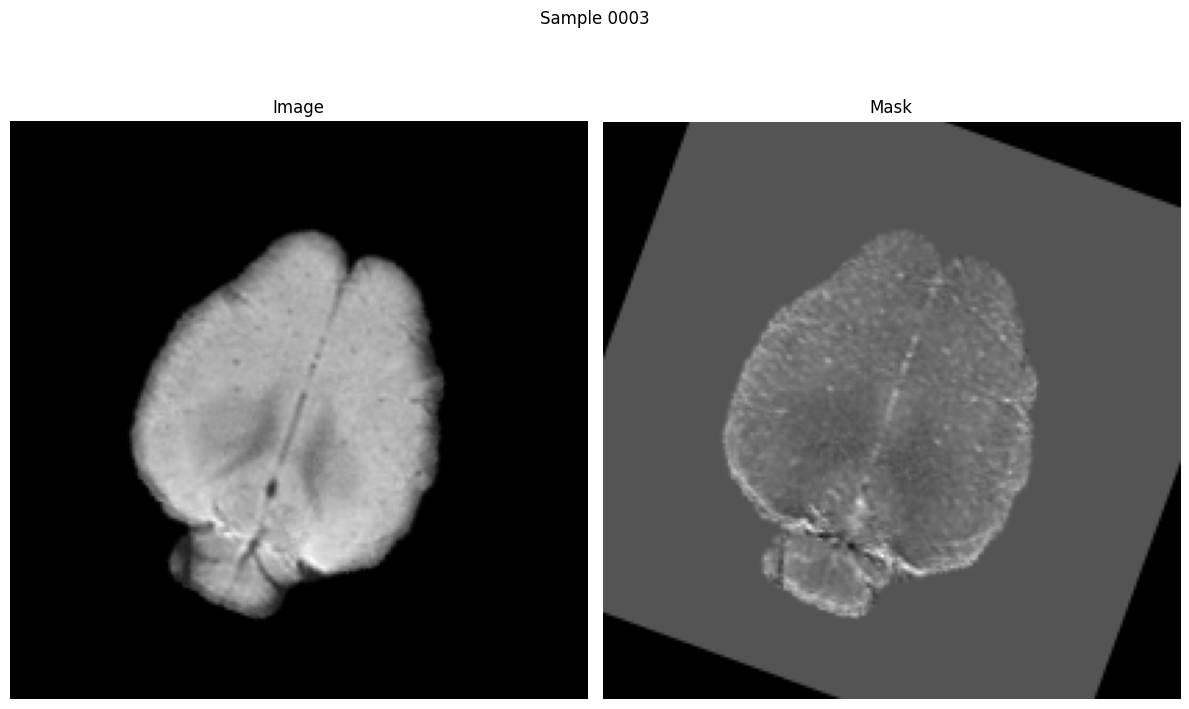

In [26]:
sample = np.random.randint(0, len(train_dataset_augmented))
data = train_dataset_augmented.__getitem__(sample)
x = data['image']
y = data['mask']
idx = data['img_id']

print(f'x shape is {x.shape}')
print(f'y shape is {y.shape}')

plt.figure(figsize=(12, 8), dpi=100)
plt.suptitle(f'Sample {idx:04d}')

## USE THIS SECTION IF USING ALL 18 CHANNELS
img = x[3,:,:]
mask = y[3,:,:]

## USE THIS SECTION IF USING ONLY ONE CHANNEL PER PATIENT
#img = x[0,:,:]
#mask = y[0,:,:]


plt.subplot(1, 2, 1)
plt.title('Image')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Mask')
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

Merge the augmented and non-augmented datasets together in a dataloader

In [27]:
# Re-create train, validation, and test dataset instances to reduce the number of samples and expedite the training process.
train_dataset_augmented = BasicDataset('Train', n_sample=numTrain)
valid_dataset_augmented = BasicDataset('Valid', n_sample=numValid)
test_dataset_augmented = BasicDataset('Test', n_sample=numTest)


train_dataloader = DataLoader(ConcatDataset([train_dataset, train_dataset_augmented]), batch_size=3, shuffle=True, num_workers=2, pin_memory=True)
valid_dataloader = DataLoader(ConcatDataset([valid_dataset, valid_dataset_augmented]), batch_size=3, num_workers=2, pin_memory=True)
test_dataloader = DataLoader(ConcatDataset([test_dataset, test_dataset_augmented]), batch_size=3, num_workers=2, pin_memory=True)

Redefine out new model and particularly the new layers

In [28]:
######################################## Double Convolution
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

    
######################################## Maxpooling followed by Double Convolution
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


######################################## Upsampling followed by Double Convolution
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up_conv = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0),
        ) 
        self.conv = DoubleConv(out_channels * 2, out_channels)


    def forward(self, x1, x2):
        x1 = self.up_conv(x1)
        x = torch.cat([x1, x2], dim=1)
        x = self.conv(x)
        return x
    
    
### NEW RESIDUAL BLOCK [2] (Adapted from https://towardsdatascience.com/residual-network-implementing-resnet-a7da63c7b278)
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation='relu'):
        super().__init__()
        self.in_channels, self.out_channels, self.activation = in_channels, out_channels, activation
        self.blocks = nn.Identity()
        self.activate = activation_func(activation)
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        x = self.activate(x)
        return x

######################################## Output layer (1x1 Convolution followed by SoftMax activation)
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv_sigmoid = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.conv_sigmoid(x)

Implement new model with residual blocks

In [29]:
class UNet(nn.Module):
    
    
    
    def __init__(self, name, n_channels, n_classes):
        super(UNet, self).__init__()
        self.name = name
        self.n_channels = n_channels
        self.n_classes = n_classes
        '''[(Q3) Adding additional encoding and decoding layers below]'''
        self.inputL = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.res1 = ResidualBlock(128,128)
        self.down2 = Down(128, 256)
        self.res2 = ResidualBlock(256,256)
        self.down3 = Down(256, 512)
        self.res3 = ResidualBlock(512,512)
        self.down4 = Down(512, 1024)
        
        self.up1 = Up(1024, 512)
        self.res4 = ResidualBlock(512,512)
        self.up2 = Up(512, 256)
        self.res5 = ResidualBlock(256,256)
        self.up3 = Up(256, 128)
        self.res6 = ResidualBlock(128,128)
        self.up4 = Up(128, 64)
        self.outputL = OutConv(64, n_classes)
        
        '''[(Q3) Modify the forward module below]'''
    def forward(self, x):
        x1 = self.inputL(x)
        
        x2 = self.down1(x1)
        resDown1 = self.res1(x2)
        x3 = self.down2(resDown1)
        resDown2 = self.res2(x3)
        x4 = self.down3(resDown2)
        resDown3 = self.res3(x4)
        
        b = self.down4(resDown3)
        
        x = self.up1(b, x4)
        x = self.res4(x)
        x = self.up2(x, x3)
        x = self.res5(x)
        x = self.up3(x, x2)
        x = self.res6(x)
        x = self.up4(x, x1)
        
        x = self.outputL(x)
        
        return x

Instantiate the new model

In [30]:
new_UNet = UNet('NewUNet', inp_channel, opt_channel)
new_UNet.cuda()

UNet(
  (inputL): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(18, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, mo

Train the new model

In [31]:
EPOCHS = 80
train_loss, train_jaccard, valid_loss, valid_jaccard = train_net(new_UNet, EPOCHS, train_dataloader, valid_dataloader, optimizer, loss_function)

EPOCH 1/80 - Training Loss: 0.7208479604413432, Training Jaccard score: 0.7040634751319885, Validation Loss: 0.6961360772450765, Validation Jaccard score: 0.6777728199958801
EPOCH 2/80 - Training Loss: 0.7206353602870819, Training Jaccard score: 0.7037861943244934, Validation Loss: 0.7111145953337351, Validation Jaccard score: 0.6904445290565491
EPOCH 3/80 - Training Loss: 0.7208034723035751, Training Jaccard score: 0.7047619819641113, Validation Loss: 0.7175634602705637, Validation Jaccard score: 0.6929134726524353
EPOCH 4/80 - Training Loss: 0.7208931119211258, Training Jaccard score: 0.7054232954978943, Validation Loss: 0.7158063848813375, Validation Jaccard score: 0.6954500675201416
EPOCH 5/80 - Training Loss: 0.7208645939826965, Training Jaccard score: 0.7039819955825806, Validation Loss: 0.7163954675197601, Validation Jaccard score: 0.6963301301002502
EPOCH 6/80 - Training Loss: 0.720862171342296, Training Jaccard score: 0.70682293176651, Validation Loss: 0.7170228858788809, Vali

Load the best performing model

In [32]:
best_epoch = np.argmax(valid_jaccard) + 1 # The plus one is because the epochs starts at 1.

print(f'Best epoch is epoch{best_epoch}')

state_dict = torch.load(f'./NewUNet/epoch_{best_epoch:03}.pth')

new_UNet.load_state_dict(state_dict)
new_UNet.cuda()

Best epoch is epoch77


UNet(
  (inputL): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(18, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, mo

Compare the performance of the old and new models

In [36]:
test_loss, test_jaccard = test_net(my_UNet, test_dataloader, loss_function)

print(f'PARTIAL U-NET: Test Loss: {test_loss}, Test Jaccard score: {test_jaccard}')

test_loss, test_jaccard = test_net(new_UNet, test_dataloader, loss_function)

print(f'FULLY IMPLEMENTED U-NET: Test Loss: {test_loss}, Test Jaccard score: {test_jaccard}')

PARTIAL U-NET: Test Loss: 0.6242867112159729, Test Jaccard score: 0.6429850459098816
FULLY IMPLEMENTED U-NET: Test Loss: 0.7295028567314148, Test Jaccard score: 0.676640510559082
